# Reasoning and Descision Making under Uncertainty

## Portfolio Exam 2

### Sensor Fusion - Particle Filter

#### ===========================================================================================

### Group 17

#### Deekshith Jagadeesh - (10000759) - deekshith.jagadeesh@study.thws.de 
#### Harshith Babu Prakash Babu - (10001191) - harshithbabu.prakashbabu@study.thws.de



#### ===========================================================================================

### Task P2.1

#### Realize an implementation of the Particle Filter in a programming language of your choice for a simulation of the ball-throwing example from the lecture slides. The task of your Particle Filter is to estimate the positions and velocity vectors of n ≥ 1 balls flying simultaneously only from the observed erroneous positions over time.
 
##### * Simulate the trajectory of n balls with the parameters launch position (x,y) (the imaginary ground is at y = 0), launch speed and launch angle/launch direction of each ball. The inital positions and flying directions of the balls are unknown to your estimation. You can only assume that the ball starts within a rather large range of, for example, 50 × 50 meters.

##### * Simulate the observations of the ball positions (x,y). The estimated ball positions shall be subject to high uncertainty and it shall be possible to parameterize this uncertainty. In addition, the time span between two observations shall be variable and the observations shall be able to drop out completely over a certain period of time. It is necessary that the positions of the ball is also estimated during the time of the sensor failure.

##### * How to deal with more than one ball flying at the same time? How do you define your state? Think intensively about what the transition model and the evaluation model should look like in the case of n balls.How do you estimate n positions from the sensor fusion density? If the density of the ball positions is multimodal, select a suitable method that can determine the positions of the balls.

##### * You are not able to distinguish between the balls. They are indistinguishable from an observational point of view.
  
##### * The starting position and other starting parameters are just as unknown and cannot be specified more precisely. You should handle both the case where the starting positions and directions of the balls are very similar and the case where the positions and directions are clearly different in one common approach.
 
#### Note: There is more than one good approach here. Thus, there is no clear best solution approach in this task.

#### ===========================================================================================
#### ===========================================================================================

### Importing Required Libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt  
from sklearn.cluster import KMeans 

### Simulate Ground Truth Trajectories Using Projectile Motion

In [2]:
# Projectile Simulation Functions 

# Function to simulate a single projectile's flight path
# Simulates the trajectory and velocity of a projectile given its initial conditions.
def simulate_projectile(init_x, init_y, speed, launch_angle, num_points=50):
    
    g = 9.81  # Acceleration due to gravity (m/s^2)

    # Convert launch angle from degrees to radians, as trigonometric functions in Python use radians.
    angle_rad = np.deg2rad(launch_angle)

    # Calculate the total time the projectile stays in the air. This assumes it lands at the initial y-level.
    flight_time = (2 * speed * np.sin(angle_rad)) / g

    # Create an array of time steps, from the moment of launch (0) to the end of its flight.
    times = np.linspace(0, flight_time, num_points)

    # Calculate horizontal positions. Horizontal velocity is constant (ignoring air resistance).
    x_vals = init_x + speed * np.cos(angle_rad) * times

    # Calculate vertical positions. This accounts for initial upward velocity and the effect of gravity pulling it down.
    y_vals = init_y + speed * np.sin(angle_rad) * times - 0.5 * g * times**2

    # Horizontal velocity (vx) remains constant throughout the flight, as there's no horizontal force.
    vx = speed * np.cos(angle_rad)

    # Vertical velocity (vy) changes linearly due to gravity. It decreases on the way up and increases on the way down.
    vy = speed * np.sin(angle_rad) - g * times

    # Calculate the resultant (total) velocity at each point using the Pythagorean theorem (sqrt(vx^2 + vy^2)).
    velocity = np.sqrt(vx**2 + vy**2)

    # Return the calculated positions (x, y) and the magnitude of the velocity at each time step.
    return x_vals, y_vals, velocity

In [3]:
# Define the acceptable ranges for random initial conditions for our projectiles.
x_range = (0, 50)  # X-coordinates for initial position, in meters.
y_range = (0, 50)  # Y-coordinates for initial position, in meters.
speed_range = (30.0, 100.0)  # Initial launch speed, in meters per second.
angle_range = (15.0, 85.0)  # Launch angle from the horizontal, in degrees.

# Code for generating a single initial state 'q'.
# This block sets up a single, "true" initial state for a hypothetical target.
# This 'q' could represent the actual, unobserved state that a tracking filter (like a particle filter) would try to estimate.

# Randomly pick an initial X position within the defined range.
initial_x = np.random.uniform(x_range[0], x_range[1])
# Randomly pick an initial Y position within the defined range.
initial_y = np.random.uniform(y_range[0], y_range[1])
# Randomly pick an initial speed.
initial_speed = np.random.uniform(speed_range[0], speed_range[1])
# Randomly pick an initial launch angle in degrees.
initial_launch_angle_deg = np.random.uniform(angle_range[0], angle_range[1])

# Convert the angle to radians for velocity component calculations.
initial_launch_angle_rad = np.deg2rad(initial_launch_angle_deg)
# Calculate the initial horizontal velocity component.
initial_vx = initial_speed * np.cos(initial_launch_angle_rad)
# Calculate the initial vertical velocity component.
initial_vy = initial_speed * np.sin(initial_launch_angle_rad)

# Assemble the initial state 'q' as a list: [x, y, vx, vy].
# This forms a complete kinematic state vector for our single target.
q = [initial_x, initial_y, initial_vx, initial_vy]

# Print out the generated 'q' state for verification and understanding.
print(f"Generated Initial State 'q' (for a single target/ground truth):")
print(f"  Initial X position (x): {q[0]:.2f} m")
print(f"  Initial Y position (y): {q[1]:.2f} m")
print(f"  Initial X velocity (vx): {q[2]:.2f} m/s")
print(f"  Initial Y velocity (vy): {q[3]:.2f} m/s")
print(f"\n(Derived from speed: {initial_speed:.2f} m/s, launch angle: {initial_launch_angle_deg:.2f}°)")
# End of code for initial state 'q'.

# Randomly decide how many balls (projectiles) we want to simulate for this run, between 3 and 6.
num_balls = np.random.randint(3, 6)

# This list will store all the unique parameters for each individual ball,
# including their starting conditions, and also how noisy or unreliable their observations might be.
all_ball_params = []
for _ in range(num_balls):
    # For each ball, generate its own random initial position, speed, and launch angle.
    init_x = np.random.uniform(x_range[0], x_range[1])
    init_y = np.random.uniform(y_range[0], y_range[1])
    speed = np.random.uniform(speed_range[0], speed_range[1])
    launch_angle = np.random.uniform(angle_range[0], angle_range[1])

    # Also, assign random noise and observation dropout probabilities for the specific ball.
    # This simulates varied sensor quality or environmental conditions for different targets.
    ball_noise_std = np.random.uniform(0.5, 5.0)  # Standard deviation for observation noise.
    ball_dropout_prob = np.random.uniform(0.0, 0.5) # Probability that an observation for this ball is missed.

    # Store all these parameters as a dictionary for the current ball.
    all_ball_params.append({
        "init_x": init_x,
        "init_y": init_y,
        "speed": speed,
        "launch_angle": launch_angle,
        "noise_std": ball_noise_std,
        "dropout_prob": ball_dropout_prob
    })

Generated Initial State 'q' (for a single target/ground truth):
  Initial X position (x): 39.61 m
  Initial Y position (y): 46.77 m
  Initial X velocity (vx): 35.01 m/s
  Initial Y velocity (vy): 60.56 m/s

(Derived from speed: 69.95 m/s, launch angle: 59.97°)


### Plot Multiple Projectile Trajectories with Distinct Colors and Labels

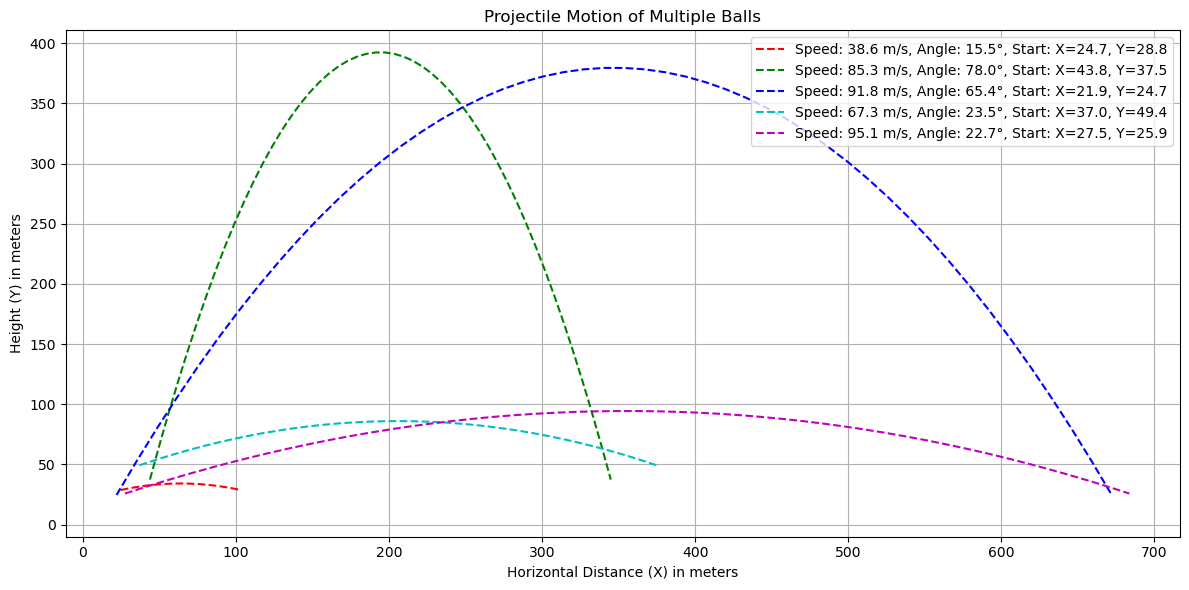

In [4]:
# Define a palette of colors to visually distinguish each projectile's path on the plot.
base_colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'tab:orange', 'tab:purple']

# If we have more balls than base colors, cycle through the colors again to ensure each ball gets one.
colors = base_colors * (num_balls // len(base_colors) + 1)

# Trim the colors list to exactly match the number of balls.
colors = colors[:num_balls]

# Create a new plotting figure with a specific size, making it wider for better visualization.
plt.figure(figsize=(12, 6))

# Plotting the Projectile Paths
# Iterate through each ball's unique parameters and its assigned color.
for ball_params, color in zip(all_ball_params, colors):
    # Extract only the kinematic initial conditions needed by our simulation function.
    conditions = {k: ball_params[k] for k in ["init_x", "init_y", "speed", "launch_angle"]}
    # Simulate the true, ideal trajectory of the current projectile.
    # We only need x and y coordinates for plotting, so we discard the velocity output with '_'.
    x_vals, y_vals, _ = simulate_projectile(**conditions)

    # Create a descriptive label for this projectile's true path to be used in the legend.
    label = (f'Speed: {conditions["speed"]:.1f} m/s, Angle: {conditions["launch_angle"]:.1f}°, '
             f'Start: X={conditions["init_x"]:.1f}, Y={conditions["init_y"]:.1f}')

    # Plot the true trajectory. We use a dashed line ('--') to indicate it's the ideal path.
    plt.plot(x_vals, y_vals, '--' + color, label=label)

# Set the title of the plot for clarity.
plt.title('Projectile Motion of Multiple Balls')
# Label the horizontal axis.
plt.xlabel('Horizontal Distance (X) in meters')
# Label the vertical axis.
plt.ylabel('Height (Y) in meters')

# Add a grid to the plot, which makes it easier to read values and estimate positions.
plt.grid(True)

# Set the lower limit of the Y-axis to -10 meters. 
# This can be useful if trajectories might temporarily dip below zero, or just to provide some visual breathing room below the origin.
plt.ylim(bottom=-10)

# Display the legend, which uses the labels we created for each trajectory, allowing us to distinguish between the different balls.
plt.legend()

# Adjust the plot layout to prevent labels or titles from overlapping, ensuring everything is readable.
plt.tight_layout()

# Finally, display the generated plot.
plt.show()

### Simulate Noisy and Incomplete Observations

In [5]:
# Function to simulate noisy measurements with optional dropout.
# Generates noisy observations from true projectile coordinates and simulates data dropout.
def simulate_noisy_observations(x_vals, y_vals, noise_std=1.0, dropout_prob=0.1):
    
    # Add random Gaussian noise to both the X and Y coordinates.
    # This simulates inaccuracies in our measurement sensors. The `noise_std` controls how much spread there is.
    noisy_x = x_vals + np.random.normal(0, noise_std, x_vals.shape)
    noisy_y = y_vals + np.random.normal(0, noise_std, y_vals.shape)
    
    # Simulate data dropout: we randomly decide which data points are "missing".
    # A `dropout_mask` is created; if a random number is greater than `dropout_prob`, the data point is kept (True).
    dropout_mask = np.random.rand(len(noisy_x)) > dropout_prob  # Keep values with (1 - dropout_prob) chance
    
    # Apply the dropout mask: for any points where `dropout_mask` is False (meaning the data should be dropped),
    # we set their values to `np.nan` (Not a Number) to represent missing data.
    noisy_x[~dropout_mask] = np.nan
    noisy_y[~dropout_mask] = np.nan
    
    # Return the observed data, which now has noise and potentially gaps.
    return noisy_x, noisy_y


### Visualize True Projectile Trajectories Alongside Noisy Observations 

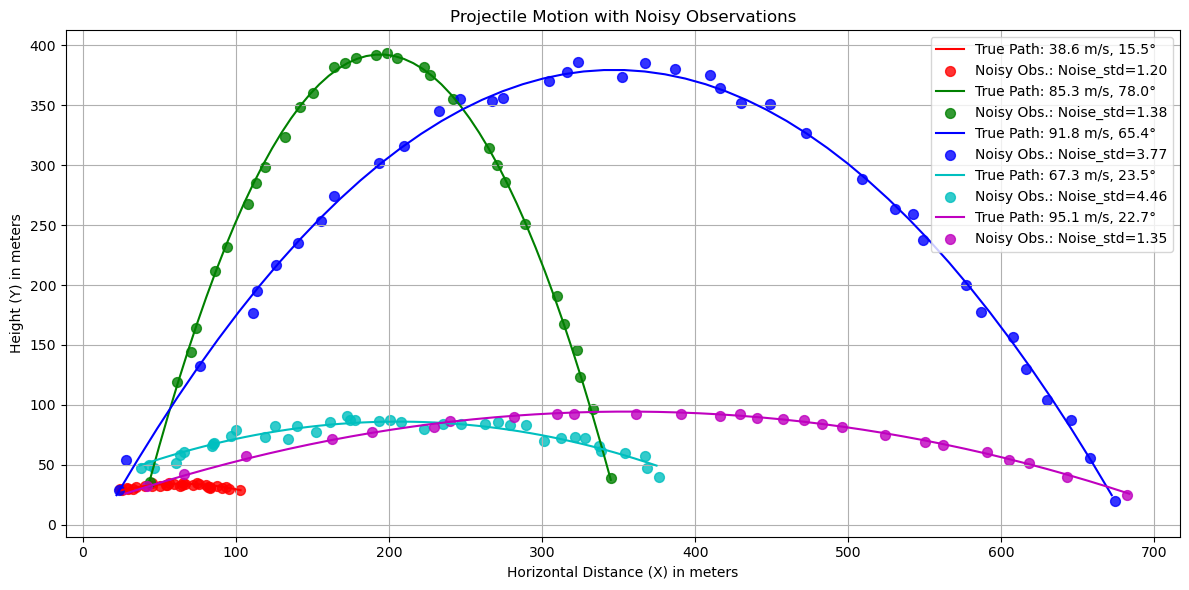

In [6]:
# Create a new figure for plotting. We'll make it fairly wide to see everything clearly.
plt.figure(figsize=(12, 6))

# Plotting Noisy Observations 
# Loop through each set of ball parameters and its assigned color.
# We'll plot both the true path and the simulated noisy observations for each.
for ball_params, color in zip(all_ball_params, colors):
    # First, get the true, ideal trajectory for the current ball using its initial conditions.
    conditions = {k: ball_params[k] for k in ["init_x", "init_y", "speed", "launch_angle"]}
    x_vals, y_vals, _ = simulate_projectile(**conditions) 

    # Grab the noise and dropout settings that were pre-assigned to this specific ball.
    noise_std = ball_params["noise_std"]
    dropout_prob = ball_params["dropout_prob"]

    # Now, simulate the noisy and incomplete observations based on the true path and the ball's unique noise/dropout parameters.
    noisy_x, noisy_y = simulate_noisy_observations(
        x_vals, y_vals,
        noise_std=noise_std,
        dropout_prob=dropout_prob
    )

    # Prepare the labels for the plot legend, distinguishing between the true path and the noisy data.
    label_real = f'True Path: {conditions["speed"]:.1f} m/s, {conditions["launch_angle"]:.1f}°'
    label_noisy = f'Noisy Obs.: Noise_std={noise_std:.2f}'

    # Plot the true trajectory as a solid line for easy comparison.
    plt.plot(x_vals, y_vals, '-' + color, label=label_real)

    # Plot the noisy observations as scatter points.
    # `s=50` controls the size of the dots, and `alpha=0.8` makes them slightly transparent.
    plt.scatter(noisy_x, noisy_y, s=50, color=color, alpha=0.8, label=label_noisy)

# Set the overall title for our plot.
plt.title('Projectile Motion with Noisy Observations')

# Label the axes so we know what we're looking at.
plt.xlabel('Horizontal Distance (X) in meters')
plt.ylabel('Height (Y) in meters')

# Add a grid to the plot for easier reading of coordinates.
plt.grid(True)

# Set the lower bound of the y-axis to -10 meters. This ensures consistency with previous plots and provides some space below ground level if needed.
plt.ylim(bottom=-10)

# Display the legend, which is crucial for understanding which line corresponds to which ball's data.
plt.legend()

# Adjust the plot layout to make sure everything fits nicely and doesn't overlap.
plt.tight_layout()

# Show the plot!
plt.show()

#### ===========================================================================================
#### ===========================================================================================

### Particle Filter Implementation for Tracking Projectile Motion

In [7]:
import numpy as np # Numerical computing library for array operations and mathematical functions.
import matplotlib.pyplot as plt # Plotting library for creating visualizations.
from sklearn.cluster import KMeans # Unused clustering algorithm from scikit-learn.
from scipy.optimize import linear_sum_assignment # Used to handle indistinguishable projectiles and hungarian algorithm for optimal assignment. 

# Helper Functions for Particle Filter 

# Initializes N particles, where each particle represents the state of all num_projectiles.
# Each particle's state is [x1, y1, vx1, vy1, x2, y2, vx2, vy2, ..., x_n, y_n, vx_n, vy_n].
# Initial states for each projectile within a particle are drawn independently from the specified ranges to represent initial uncertainty.
def initialize_unified_particles(N, num_projectiles, initial_x_range, initial_y_range, initial_speed_range, launch_angle_range, initial_noise_level):
    # Create a NumPy array to hold all particles. Each row is a particle, and columns
    # store the [x, y, vx, vy] for each projectile, concatenated.
    particles = np.zeros((N, num_projectiles * 4))

    for i in range(N): # Loop through each individual particle
        for j in range(num_projectiles): # Loop for each projectile that this particle needs to track
            idx_offset = j * 4 # Calculate the starting index for the current projectile's state within the particle

            # Randomly pick initial physical conditions (position, speed, angle) for this sub-projectile.
            # These ranges define the initial search space for our filter.
            initial_x = np.random.uniform(initial_x_range[0], initial_x_range[1])
            initial_y = np.random.uniform(initial_y_range[0], initial_y_range[1])
            initial_speed = np.random.uniform(initial_speed_range[0], initial_speed_range[1])
            launch_angle = np.random.uniform(launch_angle_range[0], launch_angle_range[1])

            # Convert the speed and angle into initial X and Y velocity components.
            initial_vx = initial_speed * np.cos(np.deg2rad(launch_angle))
            initial_vy = initial_speed * np.sin(np.deg2rad(launch_angle))

            # Assign these initial conditions to the particle, adding a bit of random noise.
            # This 'initial_noise_level' helps spread out the initial particles to cover uncertainty.
            particles[i, idx_offset + 0] = initial_x + np.random.normal(0, initial_noise_level) # x position
            particles[i, idx_offset + 1] = initial_y + np.random.normal(0, initial_noise_level) # y position
            particles[i, idx_offset + 2] = initial_vx + np.random.normal(0, initial_noise_level) # x velocity
            particles[i, idx_offset + 3] = initial_vy + np.random.normal(0, initial_noise_level) # y velocity

    return particles

# Splits the unified particle state into individual projectile states,applies projectile motion model and adds process noise to each,
# then combines them back into the unified particle state.
def predict_unified_motion(particles, delta_t, num_projectiles, process_noise_x, process_noise_y):

    N = particles.shape[0] # Get the total number of particles

    # We update each projectile's state independently within every particle.
    for j in range(num_projectiles):
        idx_offset = j * 4 # Determine where this projectile's data starts in the particle array

        # Extract the current position and velocity for the j-th projectile from all particles.
        x = particles[:, idx_offset + 0]
        y = particles[:, idx_offset + 1]
        vx = particles[:, idx_offset + 2]
        vy = particles[:, idx_offset + 3]

        # Predict the new position and velocity based on projectile motion equations.
        # This is our motion model: where we expect the projectile to go next.
        x_pred = x + vx * delta_t
        y_pred = y + vy * delta_t - 0.5 * G * delta_t**2
        vy_pred = vy - G * delta_t # Vertical velocity changes due to gravity

        # Implement a simple ground constraint: if the predicted y position goes below zero,
        # we assume it has landed and set its height to zero.
        y_pred[y_pred < 0] = 0

        # Add 'process noise' to the predicted positions. This accounts for
        # imperfections in our motion model or unmodeled accelerations.
        x_pred += np.random.normal(0, process_noise_x, N)
        y_pred += np.random.normal(0, process_noise_y, N)
        # We could also add noise to velocities if our model allowed for changes in velocity beyond gravity.

        # Update the particle states with the new predicted positions and velocities.
        particles[:, idx_offset + 0] = x_pred
        particles[:, idx_offset + 1] = y_pred
        particles[:, idx_offset + 2] = vx # Horizontal velocity (vx) remains constant in this basic model
        particles[:, idx_offset + 3] = vy_pred # Updated vertical velocity

    return particles

# Updates particle weights based on observed measurements for indistinguishable balls.
# Uses the Hungarian algorithm (linear_sum_assignment) to find the best assignment
# between predicted projectile positions within a particle and the actual observations.
def update_unified_particle_weights(particles, weights, observations, num_projectiles, measurement_noise):

    N = particles.shape[0] # Total number of particles
    num_observations = len(observations) # Number of actual measurements received at this timestep

    if num_observations == 0:
        # If there are no observations at this timestep (e.g., during a full sensor dropout),
        # the weights of the particles don't change as there's no new information.
        return weights

    # Convert the list of observations into a NumPy array for easier calculations.
    observations_np = np.array(observations)

    new_weights = np.zeros(N) # Array to store the newly calculated likelihood for each particle

    for p_idx in range(N): # Iterate through each individual particle
        particle_predicted_positions = []
        # For the current particle, gather the predicted positions for all the projectiles it tracks.
        for j in range(num_projectiles):
            idx_offset = j * 4
            predicted_x = particles[p_idx, idx_offset + 0]
            predicted_y = particles[p_idx, idx_offset + 1]
            particle_predicted_positions.append([predicted_x, predicted_y])
        particle_predicted_positions_np = np.array(particle_predicted_positions)

        # Create a 'cost matrix'. This matrix will hold the "cost" (e.g., distance)
        # of associating each predicted projectile position (from this particle) with each actual observation.
        cost_matrix = np.zeros((num_projectiles, num_observations))

        # Fill the cost matrix: for every possible pair of predicted position and observation,
        # calculate the squared Euclidean distance. This distance represents the "mismatch cost".
        for i in range(num_projectiles):
            for j in range(num_observations):
                cost_matrix[i, j] = np.sum((particle_predicted_positions_np[i] - observations_np[j])**2)

        # Use the Hungarian algorithm (`linear_sum_assignment`). This algorithm finds the
        # optimal (lowest total cost) way to assign each predicted projectile to an observation,
        # considering they are indistinguishable.
        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        # Sum the costs (squared distances) for the optimal assignments found by the Hungarian algorithm.
        sum_of_squared_errors = cost_matrix[row_ind, col_ind].sum()

        # Calculate the likelihood of this particle's state given the observations.
        # We use a Gaussian-like function: particles that predict observations closer to reality
        # will have higher likelihoods (and thus higher weights).
        # We normalize by `num_observations` to make the likelihood less sensitive to the number of observations.
        if num_observations > 0:
            likelihood = np.exp(-0.5 * sum_of_squared_errors / (measurement_noise**2 * num_observations))
        else:
            likelihood = 1.0 # This case should ideally be handled before calling this function, but ensures robustness.

        new_weights[p_idx] = likelihood

    # Update the particle weights by multiplying with the calculated likelihoods.
    weights *= new_weights
    weights += 1.e-300 # Add a tiny value to prevent division by zero or underflow if all weights become zero.
    weights /= np.sum(weights) # Normalize the weights so they sum to 1.0.

    return weights

# Calculates the effective sample size (ESS). A low ESS indicates weight degeneracy,
#meaning most of the weight is concentrated in a few particles, requiring resampling.
def effective_sample_size(weights):
    return 1.0 / np.sum(np.square(weights))

# Resamples particles based on their weights using systematic resampling.
# Particles with higher weights are more likely to be duplicated, and those with low weights are more likely to be eliminated.
def resample_particles(particles, weights):
    N = len(particles)
    # Randomly select `N` particle indices, with the probability of selection
    # proportional to their current weights.
    indices = np.random.choice(N, N, p=weights, replace=True)
    particles[:] = particles[indices] # Replace current particles with the selected ones (in-place update).
    weights[:] = np.ones(N) / N # After resampling, reset all weights to be uniform again.
    return particles, weights

# Estimates the position of each projectile by taking the weighted average of the corresponding components across all particles.
# Returns a list of [x, y] estimates for each projectile.
def estimate_unified_positions(particles, weights, num_projectiles):
    estimated_positions = []
    # For each projectile we are tracking:
    for j in range(num_projectiles):
        idx_offset = j * 4 # Get the offset for its state in the unified particle
        # Calculate the weighted average for the X and Y coordinates for this specific projectile across all particles.
        estimated_x = np.average(particles[:, idx_offset + 0], weights=weights)
        estimated_y = np.average(particles[:, idx_offset + 1], weights=weights)
        estimated_positions.append(np.array([estimated_x, estimated_y]))
    return estimated_positions

# Simulation Functions 
# Simulates true trajectories and generates noisy observations for multiple projectiles.
# Returns lists of true trajectories, and a list of lists of observations (actual measurements
# received by the sensor at each timestep, potentially with dropouts).
def simulate_projectile_measurements(t, projectile_params_list, g, measurement_noise_overall):
    all_x_true_full = [] # Stores full true X trajectories for each projectile
    all_y_true_full = [] # Stores full true Y trajectories for each projectile
    projectile_landing_steps = [] # Records the time step when each projectile lands

    # Calculate the complete true trajectory for each projectile.
    for params in projectile_params_list:
        # Calculate initial velocity components from speed and angle.
        initial_vx = params['initial_speed'] * np.cos(np.deg2rad(params['launch_angle']))
        initial_vy = params['initial_speed'] * np.sin(np.deg2rad(params['launch_angle']))
        
        # Calculate X and Y positions over time using projectile motion equations.
        x_true_full = params['initial_x'] + initial_vx * t
        y_true_full = params['initial_y'] + initial_vy * t - 0.5 * g * t**2

        # Determine when the projectile lands (Y position drops below 0).
        landing_idx = np.where(y_true_full < 0)[0]
        if len(landing_idx) > 0:
            # If it lands, set subsequent Y positions to 0 (it stays on the ground).
            y_true_full[landing_idx[0]:] = 0
            max_plot_idx = landing_idx[0] # Mark the step it landed for plotting limits
        else:
            max_plot_idx = len(t) - 1 # If it never lands within `t`, use the full trajectory.

        all_x_true_full.append(x_true_full)
        all_y_true_full.append(y_true_full)
        projectile_landing_steps.append(max_plot_idx)

    # Generate observations for the sensor at each time step.
    all_observed_measurements = [] # List of lists of [x,y] observations at each timestep.
                                   # This list will be passed to the particle filter.

    # These lists are specifically for plotting the noisy observations.
    # They will contain `NaN` values during dropout periods to show gaps in the plot.
    all_x_plot_observed = [[] for _ in range(len(projectile_params_list))]
    all_y_plot_observed = [[] for _ in range(len(projectile_params_list))]

    for i in range(len(t)): # Iterate through each time step of the simulation
        current_timestep_observations = [] # Store observations collected at this specific timestep
        for j, params in enumerate(projectile_params_list): # For each projectile
            if i > projectile_landing_steps[j]:
                # If the projectile has already landed, no more observations for it.
                all_x_plot_observed[j].append(np.nan)
                all_y_plot_observed[j].append(np.nan)
                continue # Skip to the next projectile

            # Check if the current time step falls within a defined dropout period for THIS projectile.
            is_in_dropout = False
            for dp in params['dropout_periods']:
                if dp['start_step'] <= i < dp['end_step']:
                    is_in_dropout = True
                    break # Found an active dropout period, no observation generated.

            if not is_in_dropout:
                # If NOT in a dropout period, generate a noisy observation for the current projectile.
                obs_x = all_x_true_full[j][i] + np.random.normal(0, measurement_noise_overall)
                obs_y = all_y_true_full[j][i] + np.random.normal(0, measurement_noise_overall)
                obs_y = max(0, obs_y) # Ensure observations are not below ground level.

                current_timestep_observations.append(np.array([obs_x, obs_y]))
                all_x_plot_observed[j].append(obs_x)
                all_y_plot_observed[j].append(obs_y)
            else:
                # If in a dropout period, add `NaN` to the plotting lists to represent missing data.
                all_x_plot_observed[j].append(np.nan)
                all_y_plot_observed[j].append(np.nan)

        # Shuffle the observations collected at this timestep. This is crucial
        # because our sensor doesn't know which observation belongs to which projectile (indistinguishable balls).
        np.random.shuffle(current_timestep_observations)
        all_observed_measurements.append(current_timestep_observations)

    # Convert the full true trajectories to NumPy arrays, truncating them at the landing step
    # so that plots don't show trajectories going below ground before landing.
    all_x_true_full_np = [np.array(x[:landing_idx+1]) for x, landing_idx in zip(all_x_true_full, projectile_landing_steps)]
    all_y_true_full_np = [np.array(y[:landing_idx+1]) for y, landing_idx in zip(all_y_true_full, projectile_landing_steps)]


    return (all_x_true_full_np, all_y_true_full_np, projectile_landing_steps,
            all_observed_measurements, all_x_plot_observed, all_y_plot_observed)


### Initialize Simulation Parameters and Generate Noisy Observations for Dual Projectile Tracking


In [10]:
# Main Simulation Parameters

N_PARTICLES = 20000 # Number of particles for the unified filter. More particles generally mean better accuracy but slower computation.
DELTA_T = 0.05 # The time step (in seconds) for each simulation iteration.

# Constants
G = 9.81  # Acceleration due to gravity in meters per second squared.

# Define the ranges for randomly generating initial projectile parameters for both
# simulation of true paths and initial particle spread.
INITIAL_X_RANGE = (0, 50)        # Initial X position range (meters)
INITIAL_Y_RANGE = (0, 50)        # Initial Y position range (meters)
INITIAL_SPEED_RANGE = (10, 30)   # Initial launch speed range (m/s)
LAUNCH_ANGLE_RANGE = (30, 70)    # Launch angle range (degrees from horizontal)

# Process noise represents the uncertainty in our motion model.
# These values affect how much particles spread out during the prediction phase.
PROCESS_NOISE_X = 0.8
PROCESS_NOISE_Y = 0.8

# Overall measurement noise represents the accuracy of our sensor observations.
# This value is used both to generate noisy data and within the particle filter's likelihood calculation.
MEASUREMENT_NOISE_OVERALL = 1.5

# Initial noise for particles. This determines how widely the initial particles
# are spread around their starting points. A larger value means more initial uncertainty.
INITIAL_PARTICLE_SPREAD_NOISE = 1.0

# Set the number of projectiles we want to track in this simulation.
NUM_PROJECTILES = 3

# Define a list of colors for plotting each projectile. If `NUM_PROJECTILES` is greater than the number of defined colors, colors will repeat.
PROJECTILE_COLORS = ['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow']
if NUM_PROJECTILES > len(PROJECTILE_COLORS):
    print("Warning: Not enough unique colors defined for all projectiles. Colors will repeat.")
    PROJECTILE_COLORS = PROJECTILE_COLORS * (NUM_PROJECTILES // len(PROJECTILE_COLORS) + 1)

# Generate and store the true, underlying parameters for each projectile.
# These define the 'ground truth' trajectories that the particle filter will try to estimate.
projectile_true_params = []
for _ in range(NUM_PROJECTILES):
    projectile_true_params.append({
        'initial_x': np.random.uniform(INITIAL_X_RANGE[0], INITIAL_X_RANGE[1]),
        'initial_y': np.random.uniform(INITIAL_Y_RANGE[0], INITIAL_Y_RANGE[1]),
        'initial_speed': np.random.uniform(INITIAL_SPEED_RANGE[0], INITIAL_SPEED_RANGE[1]),
        'launch_angle': np.random.uniform(LAUNCH_ANGLE_RANGE[0], LAUNCH_ANGLE_RANGE[1]),
        'dropout_periods': [] # Initialize an empty list for dropout periods, to be filled next.
    })

# Determine the longest flight time among all projectiles. This helps set the total duration of our simulation to ensure all trajectories are covered.
max_time_flight = 0.0
for params in projectile_true_params:
    # Use the projectile motion formula to calculate the time of flight for each projectile.
    time_flight = (params['initial_speed'] * np.sin(np.deg2rad(params['launch_angle'])) +
                    np.sqrt((params['initial_speed'] * np.sin(np.deg2rad(params['launch_angle'])))**2 + 2 * G * params['initial_y'])) / G
    if time_flight > max_time_flight:
        max_time_flight = time_flight

# Create the time array for our simulation. We extend it slightly beyond the longest flight to ensure the entire trajectory.
t = np.arange(0.0, max_time_flight * 1.5 + DELTA_T, DELTA_T)
TOTAL_TIME_STEPS = len(t)

# Define Dropout Parameters for guaranteed visibility
# This section sets up specific periods where observations for each projectile will be missing (simulating sensor blackouts or occlusions).
# We ensure each projectile has at least some observable time before and after dropout.
MIN_DROPOUT_DURATION_STEPS = 5 # Minimum number of time steps a dropout must last.
MAX_DROPOUT_DURATION_PERCENTAGE_OF_FLIGHT = 0.4 # Maximum percentage of a projectile's flight time that can be a dropout.
MIN_DROPOUT_START_PERCENTAGE_OF_FLIGHT = 0.1 # Minimum percentage into flight before a dropout can begin.

for params in projectile_true_params:
    # Calculate the actual flight duration for this specific projectile in terms of simulation steps.
    true_time_flight = (params['initial_speed'] * np.sin(np.deg2rad(params['launch_angle'])) +
                         np.sqrt((params['initial_speed'] * np.sin(np.deg2rad(params['launch_angle'])))**2 + 2 * G * params['initial_y'])) / G
    actual_flight_steps = int(true_time_flight / DELTA_T)

    if actual_flight_steps < MIN_DROPOUT_DURATION_STEPS:
        # If the projectile's flight is too short, we don't apply a dropout period.
        params['dropout_periods'] = []
        continue

    # Determine the latest possible step a dropout can start while still meeting the minimum duration.
    max_possible_dropout_start_step = max(0, actual_flight_steps - MIN_DROPOUT_DURATION_STEPS)

    # Define valid starting steps for a dropout, ensuring it doesn't start too early and has enough time to complete its minimum duration.
    start_step_candidates = np.arange(
        int(MIN_DROPOUT_START_PERCENTAGE_OF_FLIGHT * actual_flight_steps),
        max_possible_dropout_start_step + 1
    )

    if len(start_step_candidates) == 0:
        start_step = 0 # Fallback if no valid range for dropout start.
    else:
        start_step = np.random.choice(start_step_candidates) # Randomly pick a valid start step.

    # Determine the maximum allowed dropout duration and then pick a random duration within limits.
    max_duration_steps = int(MAX_DROPOUT_DURATION_PERCENTAGE_OF_FLIGHT * actual_flight_steps)
    dropout_duration_steps = np.random.randint(MIN_DROPOUT_DURATION_STEPS, max(MIN_DROPOUT_DURATION_STEPS + 1, max_duration_steps + 1))

    # Calculate the end step for the dropout period.
    end_step = start_step + dropout_duration_steps
    if end_step > actual_flight_steps:
        # Adjust if the dropout period extends beyond the projectile's flight time.
        end_step = actual_flight_steps
        if (end_step - start_step) < MIN_DROPOUT_DURATION_STEPS:
            # If adjustment makes the dropout too short, re-adjust the start step.
            start_step = max(0, end_step - MIN_DROPOUT_DURATION_STEPS)

    # Store the calculated dropout period, or an empty list if no valid dropout could be created.
    if start_step >= end_step:
        params['dropout_periods'] = [] # No valid dropout
    else:
        params['dropout_periods'] = [{'start_step': start_step, 'end_step': end_step}]

# Print out information about the simulated projectiles and their dropout periods for verification.
print(f"Simulating {NUM_PROJECTILES} projectiles.")
for i, params in enumerate(projectile_true_params):
    print(f"Projectile {i+1}:")
    if params['dropout_periods']:
        for dp in params['dropout_periods']:
            print(f"  Dropout period from t={dp['start_step'] * DELTA_T:.2f}s (step {dp['start_step']}) to t={dp['end_step'] * DELTA_T:.2f}s (step {dp['end_step']})")
    else:
        print("  No dropout period.")

# Initialize Particle Filter 
# Initialize the particles: each particle represents a hypothesis about the states of ALL projectiles.
particles = initialize_unified_particles(N_PARTICLES, NUM_PROJECTILES,
                                         INITIAL_X_RANGE, INITIAL_Y_RANGE,
                                         INITIAL_SPEED_RANGE, LAUNCH_ANGLE_RANGE,
                                         INITIAL_PARTICLE_SPREAD_NOISE)
# Initially, all particles are equally likely, so their weights are uniform.
weights = np.ones(N_PARTICLES) / N_PARTICLES

# This list will store the estimated positions of each projectile at each timestep for plotting later.
all_estimated_positions = []

# Simulate the true trajectories and generate the noisy observations that the particle filter will receive.
(all_x_real_for_plot, all_y_real_for_plot, projectile_landing_steps,
 all_observed_measurements_per_timestep,
 all_x_plot_observed_individual, all_y_plot_observed_individual) = \
    simulate_projectile_measurements(t, projectile_true_params, G, MEASUREMENT_NOISE_OVERALL)

# Main Simulation Loop (Particle Filter Execution)
for i in range(TOTAL_TIME_STEPS):
    # Prediction Step: Move all particles forward in time according to our motion model and add process noise to account for model inaccuracies.
    particles = predict_unified_motion(particles, DELTA_T, NUM_PROJECTILES,
                                       PROCESS_NOISE_X, PROCESS_NOISE_Y)

    # Get the sensor observations available at the current timestep.
    current_observations = all_observed_measurements_per_timestep[i]

    # Update Step: Adjust the weights of the particles based on how well their predicted states match the actual observations. 
    # The Hungarian algorithm is used here to solve the data association problem (which observation belongs to which projectile).
    weights = update_unified_particle_weights(particles, weights, current_observations,
                                              NUM_PROJECTILES, MEASUREMENT_NOISE_OVERALL)

    # Resampling Step: Check the effective sample size (ESS). 
    # If it drops too low, it means many particles have very low weights (degeneracy). 
    # Resampling eliminates low-weight particles and duplicates high-weight ones to maintain diversity.
    if effective_sample_size(weights) < N_PARTICLES / 2.0:
        particles, weights = resample_particles(particles, weights)

    # Estimation Step: Calculate the estimated position for each projectile.
    # This is typically the weighted average of the positions across all particles.
    estimated_poses_at_timestep = estimate_unified_positions(particles, weights, NUM_PROJECTILES)

    # Store the estimated positions for plotting. Handle cases where projectiles have landed by adding NaN, so their estimated path stops at landing.
    temp_estimated_poses = []
    for j in range(NUM_PROJECTILES):
        if i > projectile_landing_steps[j]:
            temp_estimated_poses.append(np.array([np.nan, np.nan])) # Projectile landed, no more estimation
        else:
            # Ensure estimated Y position doesn't go below ground.
            temp_estimated_y = max(0.0, estimated_poses_at_timestep[j][1])
            temp_estimated_poses.append(np.array([estimated_poses_at_timestep[j][0], temp_estimated_y]))

    all_estimated_positions.append(temp_estimated_poses)


# Convert the collected estimated positions into a format suitable for plotting.
# This rearranges the data so we have a separate array for each projectile's estimated path.
estimated_paths_for_plot = [[] for _ in range(NUM_PROJECTILES)]
for t_step_estimates in all_estimated_positions:
    for j in range(NUM_PROJECTILES):
        estimated_paths_for_plot[j].append(t_step_estimates[j])
estimated_paths_for_plot = [np.array(path) for path in estimated_paths_for_plot]

# Hungarian Algorithm for Matching Estimated Paths to Real Paths for Plotting 
# This section uses the Hungarian algorithm again, but after the filter has run.
# Its purpose here is purely for visualization: to correctly match each estimated trajectory
# Without this, the estimated paths might randomly swap colors due to the indistinguishable nature.

matched_estimated_paths_for_plot = [[] for _ in range(NUM_PROJECTILES)]
num_projectiles = NUM_PROJECTILES # Re-use NUM_PROJECTILES for clarity.
total_time_steps = TOTAL_TIME_STEPS # Re-use TOTAL_TIME_STEPS for clarity.
all_estimates = estimated_paths_for_plot # Renaming for clarity in this specific section.

for i in range(total_time_steps): # Iterate through each time step
    valid_real_data = [] # Stores (original_projectile_index, real_position) for active projectiles
    valid_estimated_data = [] # Stores (original_projectile_index, estimated_position) for active estimates
    
    # Collect all currently active real and estimated positions.
    for p_idx in range(num_projectiles):
        # Check if the true projectile is still in flight (not landed).
        if i < len(all_x_real_for_plot[p_idx]):
            real_pos_x = all_x_real_for_plot[p_idx][i]
            real_pos_y = all_y_real_for_plot[p_idx][i]
            real_pos = np.array([real_pos_x, real_pos_y])
            valid_real_data.append((p_idx, real_pos))
        
        # Check if the estimated path for this projectile is valid (not NaN) at this timestep.
        est_pos = all_estimates[p_idx][i]
        if not np.isnan(est_pos).any(): # Check if either x or y is NaN
            valid_estimated_data.append((p_idx, est_pos))
            
    # If there are both true and estimated data points available to match:
    if len(valid_real_data) > 0 and len(valid_estimated_data) > 0:
        # Create a cost matrix: distance between each real position and each estimated position.
        cost_matrix = np.zeros((len(valid_real_data), len(valid_estimated_data)))
        for r_sub_idx, (real_orig_idx, real_pos) in enumerate(valid_real_data):
            for e_sub_idx, (est_orig_idx, est_pos) in enumerate(valid_estimated_data):
                cost_matrix[r_sub_idx, e_sub_idx] = np.linalg.norm(real_pos - est_pos) # Euclidean distance
        
        # Use Hungarian algorithm to find the best (lowest total distance) matching.
        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        # Initialize a temporary list to store matched estimates, filling with NaN initially.
        temp_matched_estimates = [np.array([np.nan, np.nan])] * num_projectiles

        # Assign the matched estimated positions back to their 'true' projectile indices.
        for r_sub_idx, e_sub_idx in zip(row_ind, col_ind):
            real_orig_idx = valid_real_data[r_sub_idx][0] # Get the original index of the true projectile
            estimated_pos_to_match = valid_estimated_data[e_sub_idx][1] # Get the estimated position
            temp_matched_estimates[real_orig_idx] = estimated_pos_to_match # Store it at the corresponding true projectile index
        
        # Append these matched estimates to the plotting list.
        for p_idx in range(num_projectiles):
            matched_estimated_paths_for_plot[p_idx].append(temp_matched_estimates[p_idx])

    else: # If there's no data to match (e.g., all landed or no estimates available)
        for p_idx in range(num_projectiles):
            # If the true projectile is already landed, append NaN.
            if i >= len(all_x_real_for_plot[p_idx]):
                matched_estimated_paths_for_plot[p_idx].append(np.array([np.nan, np.nan]))
            else:
                # Otherwise, if active but unestimated, append NaN.
                matched_estimated_paths_for_plot[p_idx].append(np.array([np.nan, np.nan]))

# After the loop, ensure all matched paths have the correct length by padding with NaN if necessary, 
# and convert them to NumPy arrays for efficient plotting.
for j in range(num_projectiles):
    while len(matched_estimated_paths_for_plot[j]) < total_time_steps:
        matched_estimated_paths_for_plot[j].append(np.array([np.nan, np.nan]))
    matched_estimated_paths_for_plot[j] = np.array(matched_estimated_paths_for_plot[j])

Simulating 3 projectiles.
Projectile 1:
  Dropout period from t=1.60s (step 32) to t=2.40s (step 48)
Projectile 2:
  Dropout period from t=2.70s (step 54) to t=3.40s (step 68)
Projectile 3:
  Dropout period from t=2.40s (step 48) to t=3.15s (step 63)


### Visualize Real, Noisy, and Estimated Trajectories for Dual Projectiles with Dropout Period

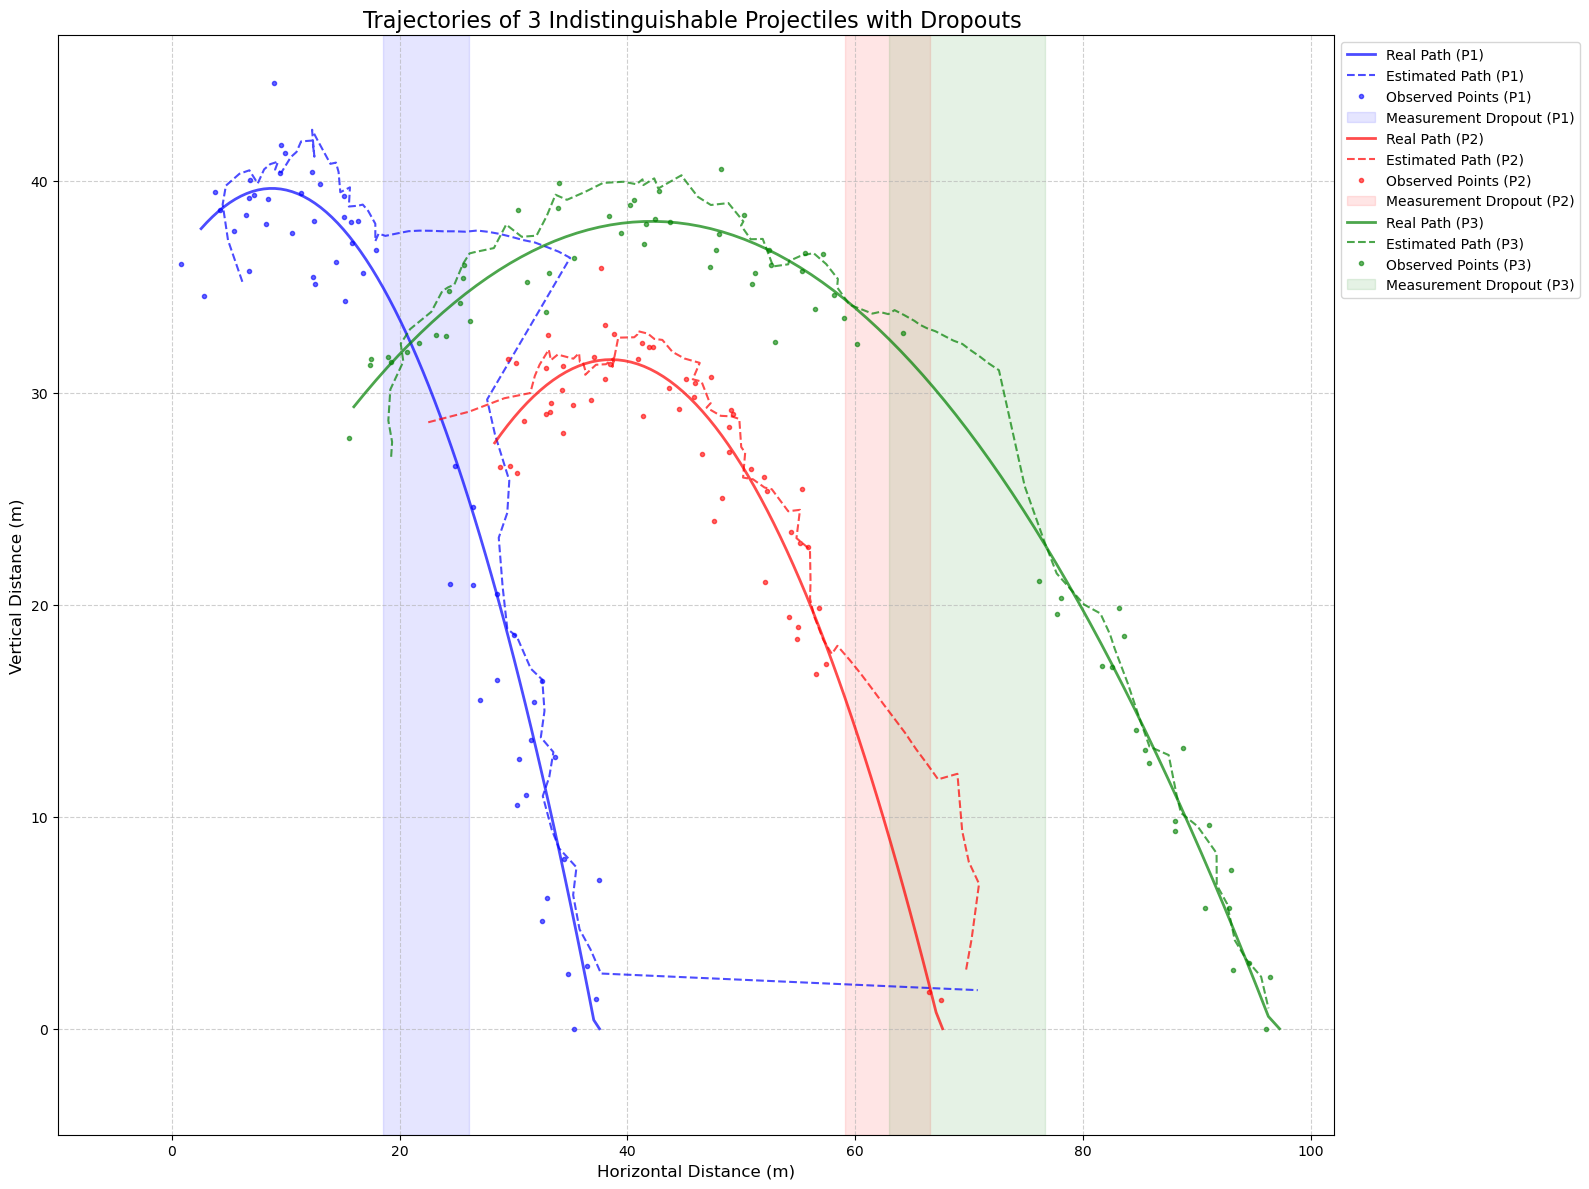

In [11]:
# Trajectory Plotting
# Create a new figure for our plot, with a larger size to accommodate multiple trajectories and legends.
plt.figure(figsize=(16,12))

# Flags to ensure that legend entries for "Real Path", "Estimated Path", "Observed Points", and "Dropout"
# are added only once per projectile, even if we plot multiple segments.
real_legend_added_per_projectile = [False] * NUM_PROJECTILES
estimated_legend_added_per_projectile = [False] * NUM_PROJECTILES
observed_legend_added_per_projectile = [False] * NUM_PROJECTILES
dropout_legend_added_per_projectile = [False] * NUM_PROJECTILES

for j in range(NUM_PROJECTILES):
    current_color = PROJECTILE_COLORS[j % len(PROJECTILE_COLORS)] # Assign a color to the current projectile

    # Plot the Real Path (ground truth) for the current projectile.
    # The `label` will only be visible in the legend for the first instance of this plot.
    label_real = f'Real Path (P{j+1})' if not real_legend_added_per_projectile[j] else "_nolegend_"
    plt.plot(all_x_real_for_plot[j], all_y_real_for_plot[j], 
             label=label_real, color=current_color, linewidth=2, alpha=0.7)
    real_legend_added_per_projectile[j] = True # Mark as added

    # Plot the Estimated Path generated by the particle filter.
    # We use a dashed line for the estimated path.
    label_estimated = f'Estimated Path (P{j+1})' if not estimated_legend_added_per_projectile[j] else "_nolegend_"
    plt.plot(matched_estimated_paths_for_plot[j][:, 0], matched_estimated_paths_for_plot[j][:, 1], 
             '--', label=label_estimated, color=current_color, markersize=4, markeredgecolor='black', alpha=0.7)
    estimated_legend_added_per_projectile[j] = True # Mark as added

    # Plot the Observed Points (noisy measurements) as individual circles.
    # These points may have gaps due to simulated dropouts.
    label_observed = f'Observed Points (P{j+1})' if not observed_legend_added_per_projectile[j] else "_nolegend_"
    plt.plot(all_x_plot_observed_individual[j], all_y_plot_observed_individual[j], 'o', 
             label=label_observed, color=current_color, alpha=0.6, markersize=3)
    observed_legend_added_per_projectile[j] = True # Mark as added

    # Plot the Dropout Periods as shaded vertical regions on the graph.
    # This visually indicates when observations for a projectile were intentionally missing.
    for dp in projectile_true_params[j]['dropout_periods']:
        start_step_plot = dp['start_step']
        end_step_plot = dp['end_step']

        # Determine the x-coordinates corresponding to the start and end of the dropout period.
        # We cap the index to ensure it doesn't go out of bounds of the `all_x_real_for_plot` array.
        start_x_dropout = all_x_real_for_plot[j][min(start_step_plot, len(all_x_real_for_plot[j]) - 1)]
        # Use `end_step_plot - 1` to correctly reflect the last observed data point before dropout,
        # ensuring the span visually covers the gap in observations.
        end_x_dropout = all_x_real_for_plot[j][min(end_step_plot -1, len(all_x_real_for_plot[j]) - 1)] 

        # Only draw the shaded region if there's an actual span (start and end X are different).
        if start_x_dropout != end_x_dropout:
            label_dropout = f'Measurement Dropout (P{j+1})' if not dropout_legend_added_per_projectile[j] else "_nolegend_"
            plt.axvspan(min(start_x_dropout, end_x_dropout), max(start_x_dropout, end_x_dropout),
                        color=current_color, alpha=0.1, label=label_dropout)
            dropout_legend_added_per_projectile[j] = True # Mark as added after the first dropout for this projectile

# Set the title of the plot.
plt.title(f'Trajectories of {NUM_PROJECTILES} Indistinguishable Projectiles with Dropouts ', fontsize=16)
# Label the axes for clarity.
plt.xlabel('Horizontal Distance (m)', fontsize=12)
plt.ylabel('Vertical Distance (m)', fontsize=12)
# Set the lower Y-limit for better visualization, ensuring ground level is visible.
plt.ylim(bottom=-5)
# Set the left X-limit for better visualization.
plt.xlim(left=-10)
# Display the legend, placing it outside the main plot area to avoid overlap.
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
# Add a grid to the plot for easier reading of positions.
plt.grid(True, linestyle='--', alpha=0.6)
# Adjust the plot layout to prevent elements from overlapping.
plt.tight_layout()
# Show the final plot.
plt.show()

#### ===========================================================================================
#### ===========================================================================================

### How to deal with more than one ball flying at the same time?

#### The code addresses this by defining a "unified" particle state. Each particle within the filter does not represent a single ball, but rather the collective state of all n projectiles. This means that within one particle, there are n sets of position and velocity components. The update step then uses the Hungarian algorithm to associate observed measurements with the predicted positions of these multiple projectiles within each particle, even though the balls are indistinguishable from an observational point of view.

### How do you define your state?

#### The state of each particle is defined as a concatenated vector comprising the individual position (x, y) and velocity (vx, vy) components for each of the n balls. Therefore, a single particle's state would look like (x1,y1,vx1,vy1,x2,y2,vx2,vy2,...,xn,yn,vxn,vyn). This comprehensive state allows the filter to model the combined dynamics of all projectiles simultaneously

### How do you estimate n positions from the sensor fusion density?

#### To estimate the n positions, the estimate_unified_positions function calculates the weighted average of the (x, y) components for each individual projectile across all particles. This process leverages the weights assigned to each particle during the update step (which reflect how well a particle's predicted state matches the observations) to derive n distinct and most probable position estimates for the balls. The Particle Filter's inherent ability to represent arbitrary probability distributions allows it to handle situations where the density might be multimodal, enabling the estimation of multiple distinct ball positions.

#### ===========================================================================================
#### ===========================================================================================